# PROJETO 2 DE CIÊNCIA DOS DADOS

Integrantes: Amanda Colucci, Gustavo Borges, João Pedro Oliveira, Sophia Braz

Prof. Fabio Ayres e Maciel Vidal

Truma A - 2° semestre

### Importando as bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from sklearn.model_selection import train_test_split
import nltk
import re
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Encontrando o arquivo:

In [2]:
file = 'Dataset-Kickstarter-projects-2018.csv'
if file in os.listdir():
    print(f'Encontramos o arquivo {file}, podemos prosseguir!')
else:
    print(f'Não encontramos o arquivo {file} no diretório {os.getcwd()}!')

Encontramos o arquivo Dataset-Kickstarter-projects-2018.csv, podemos prosseguir!


### Lendo o arquivo csv: 

In [3]:
dataset = pd.read_csv(file)
dataset.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
# Vendo os tipos de variáveis do dataset
dataset.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

### Mudando as variáveis do dataset

In [5]:
dataset['main_category'] = dataset.loc[:,'main_category'].astype('category')
dataset['currency'] = dataset.loc[:,'currency'].astype('category')
dataset['deadline'] = dataset.loc[:,'deadline'].astype('datetime64')
dataset['launched'] = dataset.loc[:,'launched'].astype('datetime64')
dataset['state'] = dataset.loc[:,'state'].astype('category')
dataset['country'] = dataset.loc[:,'country'].astype('category')

dataset.dtypes

ID                           int64
name                        object
category                    object
main_category             category
currency                  category
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                     category
backers                      int64
country                   category
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

Fazendo o delta_time e dropando as colunas que não vamos analisar

In [6]:
dataset['launched_Dates'] = pd.to_datetime(dataset['launched']).dt.date

dataset['launched_Year'] = pd.to_datetime(dataset['launched']).dt.year

dataset['launched_Month'] = pd.to_datetime(dataset['launched']).dt.month

dataset['deadline'] = pd.to_datetime(dataset['deadline']).dt.date

dataset['delta_time'] = dataset['deadline'] - dataset['launched_Dates']

dataset = dataset.drop(columns = ['ID', 'currency', 'pledged', 'usd pledged', 'category', 'launched', 'deadline', 'backers', 'launched_Dates', 'goal'])


In [7]:
# filtrando a coluna state
filtra_sucesso = dataset['state'] == 'successful'
filtra_falha = dataset['state'] == 'failed'
dataset = dataset.loc[(filtra_sucesso | filtra_falha ),:]
dataset

,name,main_category,state,country,usd_pledged_real,usd_goal_real,launched_Year,launched_Month,delta_time
0,The Songs of Adelaide & Abullah,Publishing,failed,GB,0.0,1533.95,2015,8,59 days
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,failed,US,2421.0,30000.00,2017,9,60 days
2,Where is Hank?,Film & Video,failed,US,220.0,45000.00,2013,1,45 days
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,failed,US,1.0,5000.00,2012,3,30 days
5,Monarch Espresso Bar,Food,successful,US,52375.0,50000.00,2016,2,35 days
...,...,...,...,...,...,...,...,...,...
378654,"Homemade fresh dog food, Cleveland OH",Food,failed,US,154.0,6500.00,2017,3,30 days
378657,The Tribe,Film & Video,failed,US,155.0,1500.00,2011,6,27 days
378658,Walls of Remedy- New lesbian Romantic Comedy f...,Film & Video,failed,US,20.0,15000.00,2010,7,46 days
378659,BioDefense Education Kit,Technology,failed,US,200.0,15000.00,2016,1,31 days


In [8]:
# trocando tipo de variável e associando o nome aos meses
dataset['launched_Month'] = dataset.loc[:,'launched_Month'].astype('category')
dataset['launched_Month'].cat.categories = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
dataset['launched_Month'].cat.as_ordered()
dataset

,name,main_category,state,country,usd_pledged_real,usd_goal_real,launched_Year,launched_Month,delta_time
0,The Songs of Adelaide & Abullah,Publishing,failed,GB,0.0,1533.95,2015,Agosto,59 days
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,failed,US,2421.0,30000.00,2017,Setembro,60 days
2,Where is Hank?,Film & Video,failed,US,220.0,45000.00,2013,Janeiro,45 days
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,failed,US,1.0,5000.00,2012,Março,30 days
5,Monarch Espresso Bar,Food,successful,US,52375.0,50000.00,2016,Fevereiro,35 days
...,...,...,...,...,...,...,...,...,...
378654,"Homemade fresh dog food, Cleveland OH",Food,failed,US,154.0,6500.00,2017,Março,30 days
378657,The Tribe,Film & Video,failed,US,155.0,1500.00,2011,Junho,27 days
378658,Walls of Remedy- New lesbian Romantic Comedy f...,Film & Video,failed,US,20.0,15000.00,2010,Julho,46 days
378659,BioDefense Education Kit,Technology,failed,US,200.0,15000.00,2016,Janeiro,31 days


In [9]:
dataset['launched_Year'] = dataset.loc[:,'launched_Year'].astype('category')

### Limpeza dos dados:

In [10]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english') 

def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[!-.:?;"\n"()''"",_%$\|/,<>]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    
    texto_limpo = []
    
    for w in w_tokenizer.tokenize(text_subbed):
        palavra_limpa = lemmatizer.lemmatize(w)
        texto_limpo.append(palavra_limpa)
        
    
    return texto_limpo

In [11]:
dataset['name'] = dataset['name'].astype('str')
dataset['name'] = dataset['name'].apply(cleanup)

In [12]:
dataset

,name,main_category,state,country,usd_pledged_real,usd_goal_real,launched_Year,launched_Month,delta_time
0,"[The, Songs, of, Adelaide, Abullah]",Publishing,failed,GB,0.0,1533.95,2015,Agosto,59 days
1,"[Greeting, From, Earth, ZGAC, Arts, Capsule, F...",Film & Video,failed,US,2421.0,30000.00,2017,Setembro,60 days
2,"[Where, is, Hank]",Film & Video,failed,US,220.0,45000.00,2013,Janeiro,45 days
3,"[ToshiCapital, Rekordz, Needs, Help, to, Compl...",Music,failed,US,1.0,5000.00,2012,Março,30 days
5,"[Monarch, Espresso, Bar]",Food,successful,US,52375.0,50000.00,2016,Fevereiro,35 days
...,...,...,...,...,...,...,...,...,...
378654,"[Homemade, fresh, dog, food, Cleveland, OH]",Food,failed,US,154.0,6500.00,2017,Março,30 days
378657,"[The, Tribe]",Film & Video,failed,US,155.0,1500.00,2011,Junho,27 days
378658,"[Walls, of, Remedy, New, lesbian, Romantic, Co...",Film & Video,failed,US,20.0,15000.00,2010,Julho,46 days
378659,"[BioDefense, Education, Kit]",Technology,failed,US,200.0,15000.00,2016,Janeiro,31 days


### Análise Exploratória do DataSet

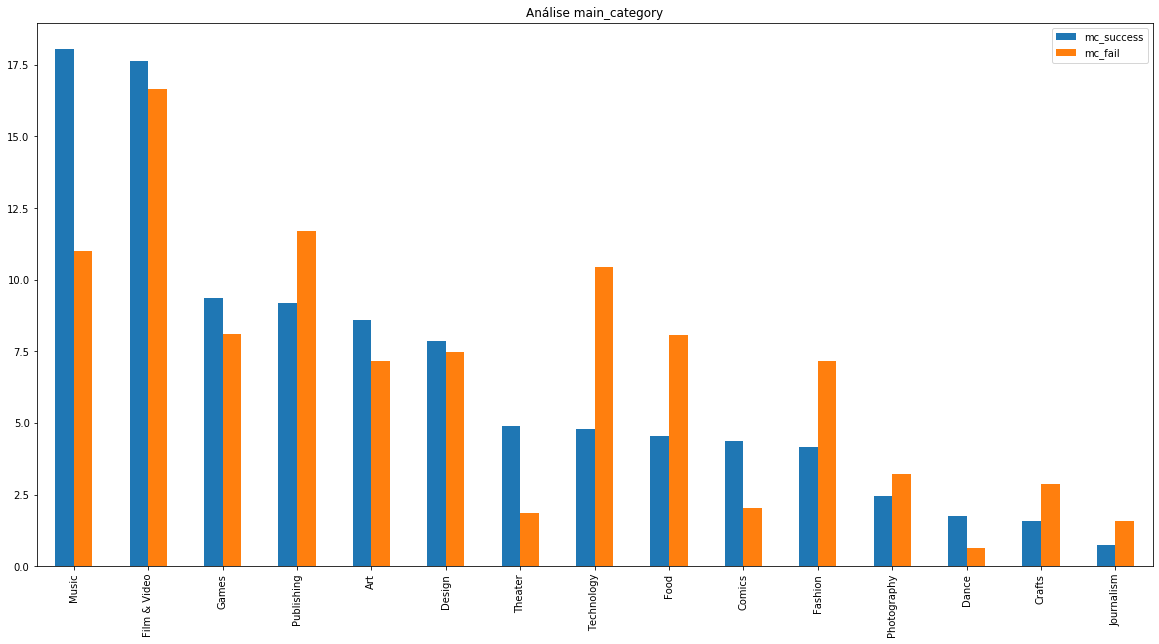

In [13]:
mc = pd.DataFrame()
mc['mc_success'] = dataset.loc[filtra_sucesso,'main_category'].value_counts(normalize = 'index')*100
mc['mc_fail'] = dataset.loc[filtra_falha,'main_category'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_mc = mc.plot.bar(ax = ax1, title = 'Análise main_category')

In [14]:
pd.crosstab(dataset.main_category, dataset.state, normalize = 'index', margins = True)*100

state,failed,successful
main_category,,
Art,55.110955,44.889045
Comics,40.858473,59.141527
Crafts,72.947045,27.052955
Dance,34.564791,65.435209
Design,58.405614,41.594386
Fashion,71.716814,28.283186
Film & Video,58.209351,41.790649
Food,72.408633,27.591367
Games,56.109533,43.890467


A partir do gráfico e da tabela acima, é possível ver que do total de categorias, mais da metade obtiveram sucesso, sendo a categoria com maior taxa de sucesso a de musica, e a de menor sucesso a de jornalismo. Já a de falha, sendo minoria, a categoria com maior taxa é a de filme e video, e a de menos é a de dança. Também é possível observar que nas categorias de Fotografia, Filme e Vídeo, Jogos e Design as taxas de sucesso e falha tem um valor muito próximo, indicando uma certa incerteza nesses resultados.

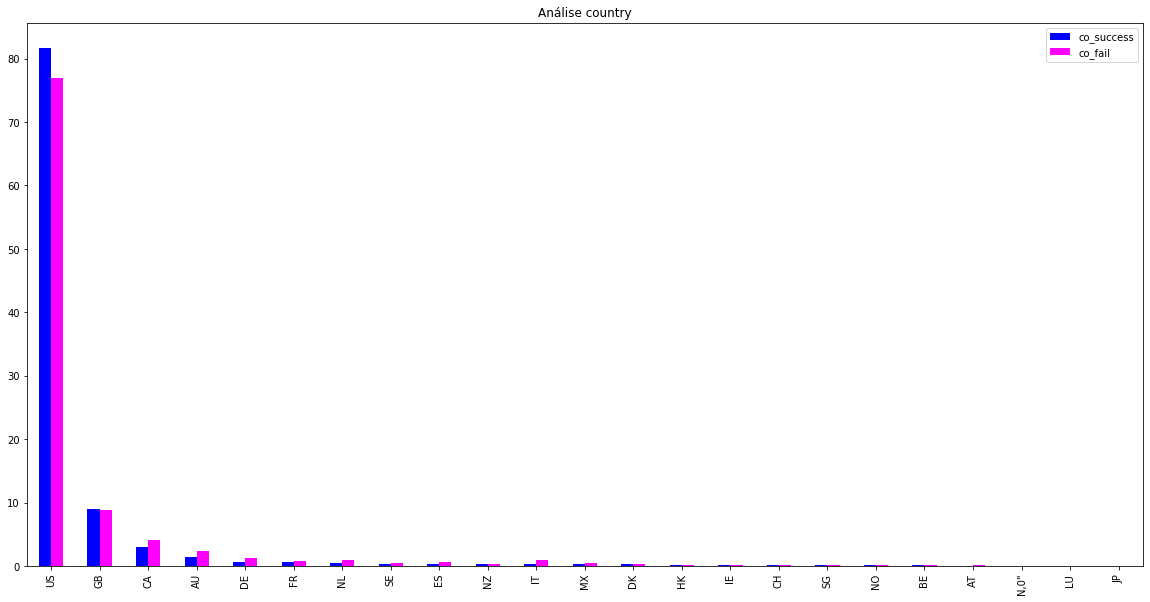

In [15]:
co = pd.DataFrame()
co['co_success'] = dataset.loc[filtra_sucesso,'country'].value_counts(normalize = 'index')*100
co['co_fail'] = dataset.loc[filtra_falha,'country'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_co = co.plot.bar(ax = ax1, title = 'Análise country', color = ['blue', 'magenta'])

In [16]:
pd.crosstab(dataset.country, dataset.state, normalize = True)*100

state,failed,successful
country,,
AT,0.113967,0.032260
AU,1.388709,0.606015
BE,0.111856,0.045828
CA,2.483154,1.246401
CH,0.140197,0.056380
DE,0.753448,0.282505
DK,0.170649,0.108540
ES,0.416371,0.148338
FR,0.486018,0.273762


Levando em consideração os países em que ocorrem as campanhas de financiamento coletivo, fica clara uma enorme diferença entre o número de campanhas feitas nos Estados Unidos e nos países restantes. Esse fato pode prejudicar nossa análise, já que os números dos Estados Unidos são extremamente grandes e os da maioria dos países são extremamente pequenos.   

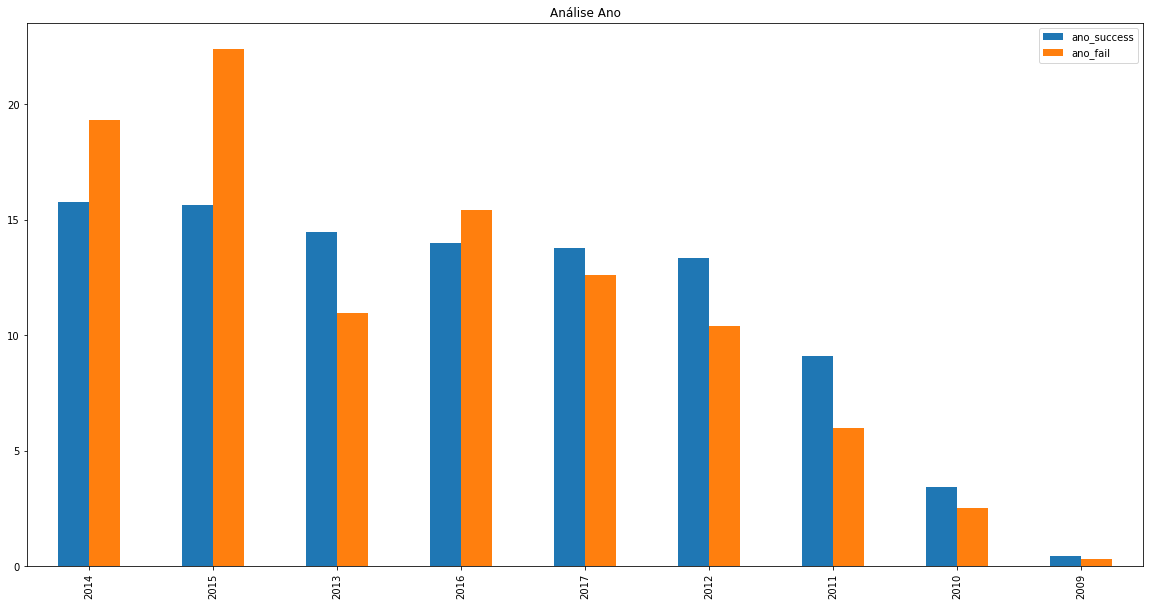

In [17]:
ano = pd.DataFrame()
ano['ano_success'] = dataset.loc[filtra_sucesso,'launched_Year'].value_counts(normalize = 'index')*100
ano['ano_fail'] = dataset.loc[filtra_falha,'launched_Year'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_ano = ano.plot.bar(ax = ax1, title = 'Análise Ano')

In [18]:
pd.crosstab(dataset.launched_Year, dataset.state, normalize = True)*100

state,failed,successful
launched_Year,,
2009,0.180900,0.174568
2010,1.502676,1.384789
2011,3.581217,3.669556
2012,6.207281,5.394437
2013,6.538328,5.853622
2014,11.516997,6.363760
2015,13.356750,6.322756
2016,9.203588,5.657948
2017,7.524535,5.566292


Com essa análise podemos ver que ao longo dos anos um maior crescimento de lançamentos, com destaque nos anos de 2014 e 2015. Porém temos que levar em consideração também que nesses anos o ínidce de falha foi muito maior do que nos outros anos. No último ano analisado (2017), a taxa de sucesso ultrapassa a de falha. 

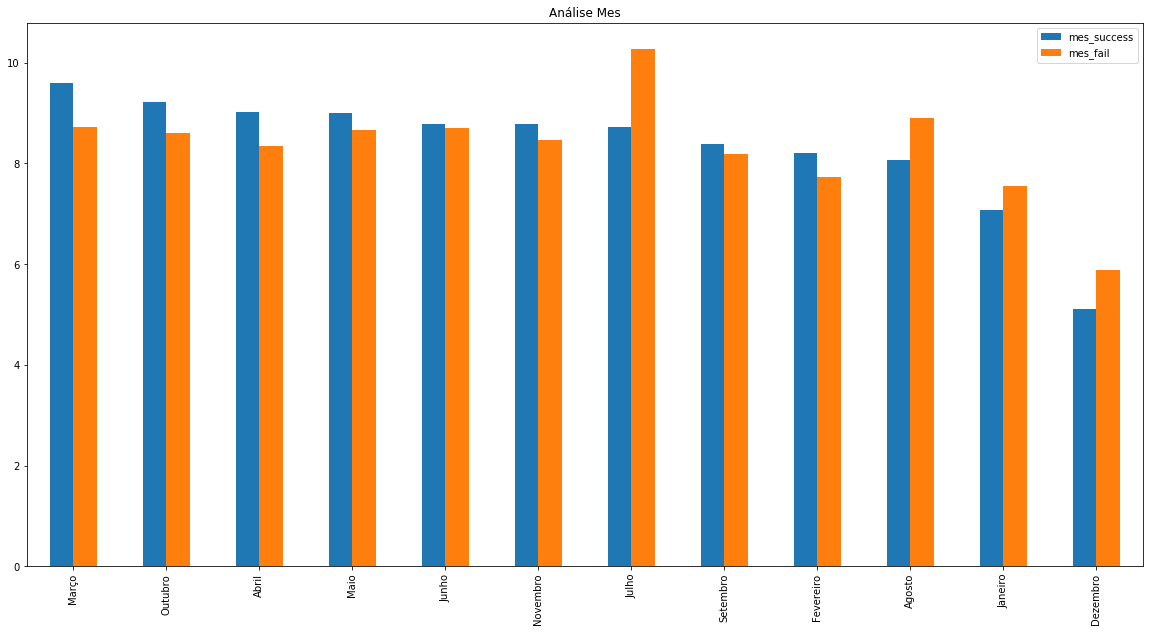

In [19]:
mes = pd.DataFrame()
mes['mes_success'] = dataset.loc[filtra_sucesso,'launched_Month'].value_counts(normalize = 'index')*100
mes['mes_fail'] = dataset.loc[filtra_falha,'launched_Month'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_mes = mes.plot.bar(ax = ax1, title = 'Análise Mes')

In [20]:
pd.crosstab(dataset.launched_Month, dataset.state, normalize = True)*100

state,failed,successful
launched_Month,,
Janeiro,4.502299,2.858220
Fevereiro,4.605110,3.317404
Março,5.200573,3.874576
Abril,4.969925,3.646039
Maio,5.159569,3.636693
Junho,5.185799,3.549559
Julho,6.128288,3.521821
Agosto,5.301877,3.262230
Setembro,4.876762,3.386146


Partindo para a análise dos meses, a primeira coisa a se notar é que os projetos que são lançados em Julho tem uma taxa de fracasso muito maior do que a dos outros meses. Nos meses de Janeiro e Dezembro, ambas as taxas são menores em comparação com os outros meses, e a taxa de fracasso costuma ser maior, o que pode se relacionar com a época festiva deste meses. 

#### Associando variáveis qualitativas com quantitativas

In [41]:
a = dataset.groupby(['state']).describe()
a.dropna(inplace = True)
a.transpose()
a

usd_pledged_real                                              \
                      count          mean            std   min      25%   
state                                                                     
failed             197719.0   1320.603817    6820.249351  0.00     2.64   
successful         133956.0  22670.795231  151090.323352  0.79  2000.00   

                                            usd_goal_real                ...  \
                50%        75%          max         count          mean  ...   
state                                                                    ...   
failed       100.00    663.000    757352.94      197719.0  63174.742222  ...   
successful  5107.25  13232.075  20338986.27      133956.0   9532.853357  ...   

                                  delta_time                           \
                75%           max      count                     mean   
state                                                                   
failed      20000.0  1.663614e+08     197719  35 days 04:09:34.997850   
successful  10000.0  2.015609e+06     133956  32 days 03:45:17.011556   

                                                                        \
                                std              min               25%   
state                                                                    
failed      13 days 04:12:09.045221  1 days 00:00:00  30 days 00:00:00   
successful  11 days 18:30:25.202469  1 days 00:00:00  30 days 00:00:00   

                                                                  
                         50%               75%               max  
state                                                             
failed      30 days 00:00:00  40 days 00:00:00  92 days 00:00:00  
successful  30 days 00:00:00  34 days 00:00:00  92 days 00:00:00  

[2 rows x 24 columns]

In [22]:
goal_success = dataset.loc[filtra_sucesso,'usd_goal_real']
goal_falha = dataset.loc[filtra_falha,'usd_goal_real']
pledged_success = dataset.loc[filtra_sucesso,'usd_pledged_real']
pledged_falha = dataset.loc[filtra_falha,'usd_pledged_real']
pledged_falha

0            0.0
1         2421.0
2          220.0
3            1.0
7          453.0
           ...  
378654     154.0
378657     155.0
378658      20.0
378659     200.0
378660     524.0
Name: usd_pledged_real, Length: 197719, dtype: float64

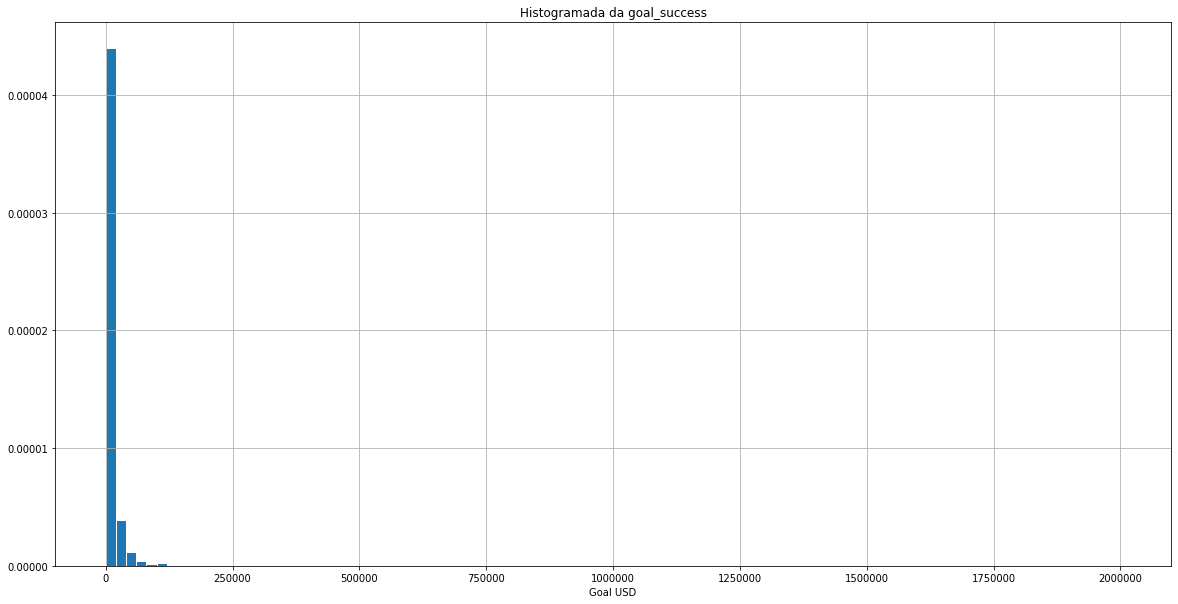

In [36]:
faixa_sucesso = np.arange(0,2.01561e+06,20000)

fig = plt.figure(figsize=(20, 10))
plt.hist(goal_success, bins = faixa_sucesso, edgecolor='white',density=True)
plt.title('Histogramada da goal_success')
plt.xlabel('Goal USD')
plt.ylabel('')
plt.grid()
plt.show()

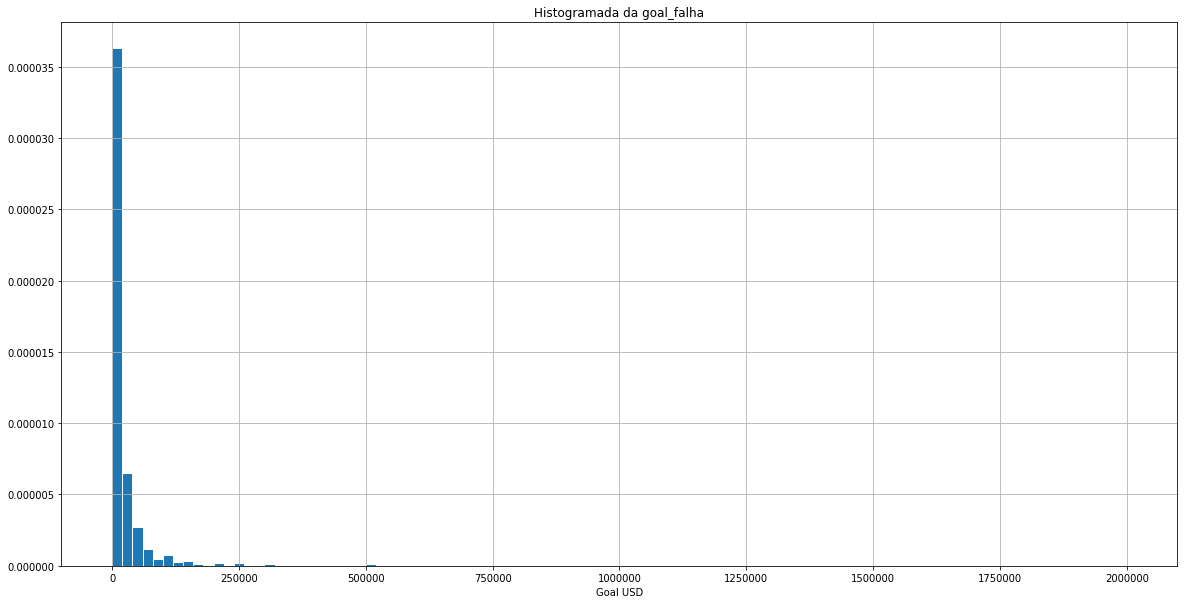

In [37]:
faixa_falha = np.arange(0,1.66361e+08,5000)

fig = plt.figure(figsize=(20, 10))
plt.hist(goal_falha, bins = faixa_sucesso, edgecolor='white', density = True)
plt.title('Histogramada da goal_falha')
plt.xlabel('Goal USD')
plt.ylabel('')
plt.grid()
plt.show()

Nesses dois histogramas acima, os objetivos de arrecadação final foram analisados. É possível notar que, quando o objetivo tem um valor muito baixo, a taxa de sucesso é maior que a taxa de falha. Também é possível notar que à medida que o valor do objetivo final aumenta, a taxa de falha supera o valor da taxa de sucesso. 

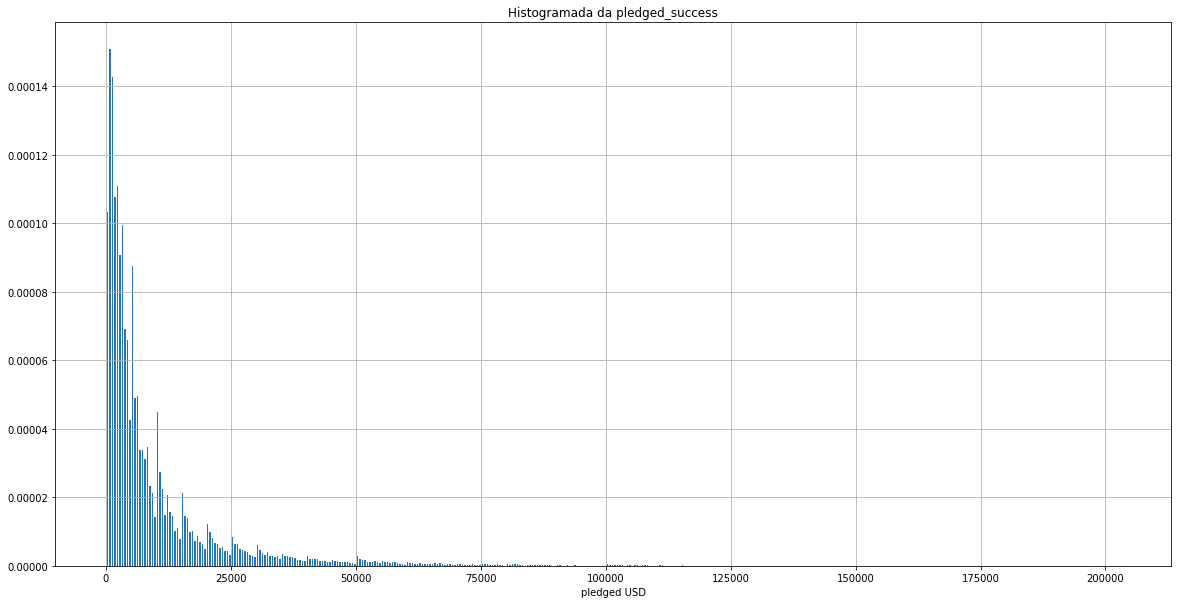

In [51]:
faixa_success_pledged = np.arange(0,2.0339e+05,500)

fig = plt.figure(figsize=(20, 10))
plt.hist(pledged_success, bins = faixa_success_pledged, edgecolor='white',density=True)
plt.title('Histogramada da pledged_success')
plt.xlabel('pledged USD')
plt.ylabel('')
plt.grid()
plt.show()

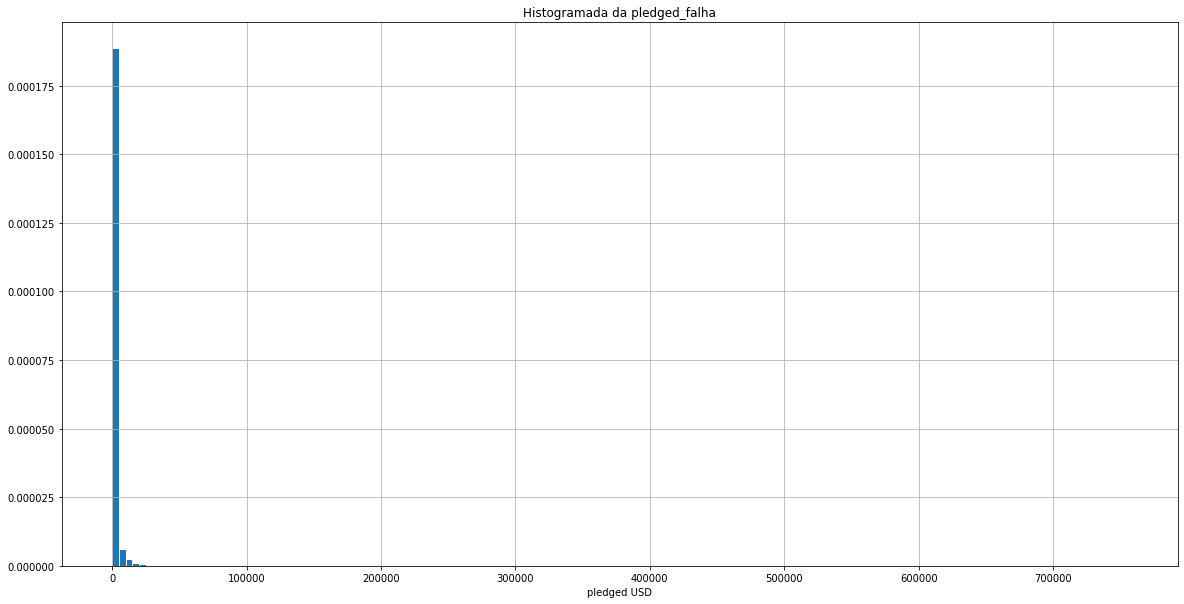

In [46]:
faixa_falha_pledged = np.arange(0,757353,5000)

fig = plt.figure(figsize=(20, 10))
plt.hist(pledged_falha, bins = faixa_falha_pledged, edgecolor='white',density=True)
plt.title('Histogramada da pledged_falha')
plt.xlabel('pledged USD')
plt.ylabel('')
plt.grid()
plt.show()

Ao analisar esses dois histogramas, é possível notar que quanto mais próximo de 0 é o valor prometido para o financiamento do projeto, maior é a taxa de falha. Além disso, podemos observar que quando esse valor aumenta, as  taxas de sucesso também aumentam e, em certo ponto, chegam a ultrapassar as taxas de falha.

In [ ]:
# splitando o teste e o treinamento 
train, test = train_test_split(dataset, test_size=0.2)

In [ ]:
#train_limpo